In [3]:
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

from tools import load_market_hist
from state_smoother import Smoother
from config.config import sql_params

In [4]:
region_id = 10000002
plot_dir = './plots'
date_range = (date(2019,5,1), date(2020,4,30))
market_data = load_market_hist(range(34,41), [region_id], *date_range, sql_params)
working_data = market_data[region_id]['average']

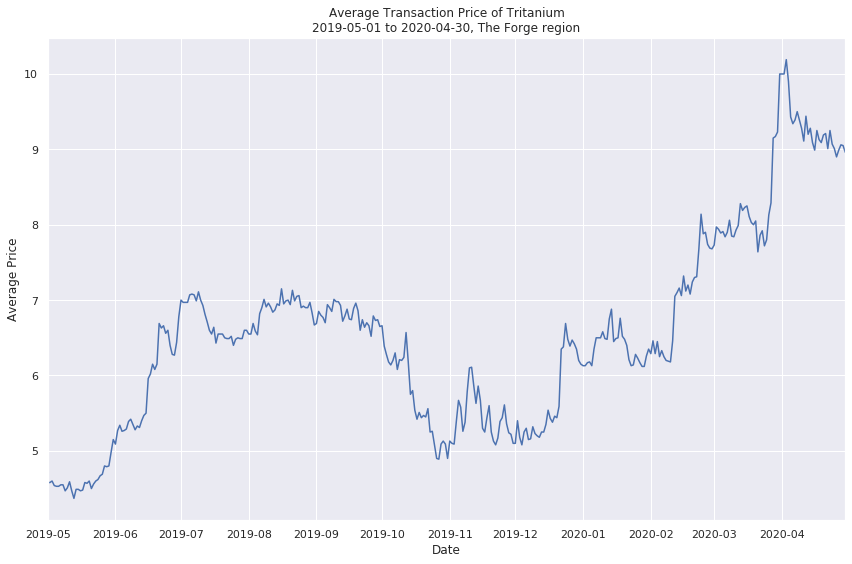

In [5]:
plt.figure(figsize=(12,8))
p = sns.lineplot(x=working_data.index, y=working_data[34])
_ = p.set(xlabel='Date', ylabel='Average Price', title='Average Transaction Price of Tritanium\n2019-05-01 to 2020-04-30, The Forge region')
_ = p.set_xlim(*date_range)
plt.tight_layout()
p.get_figure().savefig('{}/avg_trit_jita.png'.format(plot_dir))

In [ ]:
rolling_14 = working_data[34].rolling(14).mean()

In [ ]:
plt.figure(figsize=(12,8))
p = sns.lineplot(x=working_data.index, y=working_data[34], label='Actuals')
p = sns.lineplot(x=working_data.index, y=rolling_14, label='Moving Average')
_ = p.set(xlabel='Date', ylabel='Average Price', title='Average Transaction Price of Tritanium\n2019-05-01 to 2020-04-30, The Forge region\nActuals compared to 14 day rolling average smoothing')
_ = p.set_xlim(*date_range)
plt.tight_layout()
p.get_figure().savefig('{}/avg_trit_jita_roll_avg_14.png'.format(plot_dir))

In [ ]:
rolling_3 = working_data[34].rolling(3).mean()

In [ ]:
plt.figure(figsize=(12,8))
p = sns.lineplot(x=working_data.index, y=working_data[34], label='Actuals')
p = sns.lineplot(x=working_data.index, y=rolling_3, label='Moving Average')
_ = p.set(xlabel='Date', ylabel='Average Price', title='Average Transaction Price of Tritanium\n2019-05-01 to 2020-04-30, The Forge region\nActuals compared to 3 day rolling average smoothing')
_ = p.set_xlim(*date_range)
plt.tight_layout()
p.get_figure().savefig('{}/avg_trit_jita_roll_avg_3.png'.format(plot_dir))

In [ ]:
max_val = 30
plt.figure(figsize=(12,8))
p = sns.barplot(x=np.arange(max_val+1), y=0.1 * (0.9 ** np.arange(max_val+1)), color='green')
_ = p.set(
    xlabel='Timesteps back from the current timestep',
    ylabel='Percent of inclusion at the currnet timestep',
    title='Percentage impact of prior timesteps in determining the current smoothed value'
)
#_ = p.set_xlim(0, 100)
#_ = p.set_ylim(0, 0.11)
plt.tight_layout()
p.get_figure().savefig('{}/exp_smooth_window.png'.format(plot_dir))

In [ ]:
alpha = 0.1
weight_matrix = pd.DataFrame([
    alpha * ((1-alpha) ** np.flip(np.arange(n+1)))
    for n in range(len(working_data))
]).T.fillna(0)
smooth_data = working_data[34].values @ weight_matrix
seed_val = working_data.iloc[0][34]
seed_weight = 1 - weight_matrix.sum(axis=0)
final_smooth = smooth_data + (seed_val * seed_weight)

In [ ]:
plt.figure(figsize=(12,8))
p = sns.lineplot(x=working_data.index, y=working_data[34], label='Actuals')
p = sns.lineplot(x=working_data.index, y=final_smooth, label='Exponential Smoothing', color='green')
_ = p.set(
    xlabel='Date', ylabel='Average Price',
    title='Average Transaction Price of Tritanium\n2019-05-01 to 2020-04-30, The Forge region\nActuals compared to 10% flow exponential smooth'
)
_ = p.set_xlim(*date_range)
plt.tight_layout()
p.get_figure().savefig('{}/avg_trit_jita_exp_smooth_10.png'.format(plot_dir))

In [ ]:
plt.figure(figsize=(12,8))
p = sns.lineplot(x=working_data.index, y=working_data[34], label='Actuals')
p = sns.lineplot(x=working_data.index, y=final_smooth, label='Exponential Smoothing', color='green')
p = sns.lineplot(x=working_data.index, y=rolling_14, label='Moving Average')
_ = p.set(
    xlabel='Date', ylabel='Average Price',
    title='Average Transaction Price of Tritanium\n2019-05-01 to 2020-04-30, The Forge region\nActuals compared to 10% flow exponential smooth & 14 day moving average'
)
_ = p.set_xlim(*date_range)
plt.tight_layout()
p.get_figure().savefig('{}/avg_trit_jita_exp_smooth_10_and_14_move_avg.png'.format(plot_dir))

In [ ]:
alpha = 0.50
weight_matrix = pd.DataFrame([
    alpha * ((1-alpha) ** np.flip(np.arange(n+1)))
    for n in range(len(working_data))
]).T.fillna(0)
smooth_data = working_data[34].values @ weight_matrix
seed_val = working_data.iloc[0][34]
seed_weight = 1 - weight_matrix.sum(axis=0)
final_smooth_75 = smooth_data + (seed_val * seed_weight)

In [ ]:
plt.figure(figsize=(12,8))
p = sns.lineplot(x=working_data.index, y=working_data[34], label='Actuals')
p = sns.lineplot(x=working_data.index, y=final_smooth_75, label='Exponential Smoothing', color='green')
p = sns.lineplot(x=working_data.index, y=rolling_3, label='Moving Average')
_ = p.set(
    xlabel='Date', ylabel='Average Price',
    title='Average Transaction Price of Tritanium\n2019-05-01 to 2020-04-30, The Forge region\nActuals compared to 50% flow exponential smooth & 3 day moving average'
)
_ = p.set_xlim(*date_range)
plt.tight_layout()
p.get_figure().savefig('{}/avg_trit_jita_exp_smooth_50_and_3_move_avg.png'.format(plot_dir))

In [ ]:
level = [working_data.iloc[0][34]]
trend = [0]
alpha = 0.1
beta = 0.1
for idx, actual in working_data[34].iteritems():
    new_level = (alpha * actual) + ((1-alpha) * (level[-1] + trend[-1]))
    new_trend = (beta * (new_level - level[-1])) + ((1-beta) * trend[-1])
    level.append(new_level)
    trend.append(new_trend)
    
level_10 = pd.Series(level[1:], index=working_data.index)
trend = pd.Series(trend[1:], index=working_data.index)

In [ ]:
plt.figure(figsize=(12,8))
p = sns.lineplot(x=working_data.index, y=working_data[34], label='Actuals')
p = sns.lineplot(x=working_data.index, y=level_10, label='Double Exponential Smoothing', color='purple')
_ = p.set(
    xlabel='Date', ylabel='Average Price',
    title='Average Transaction Price of Tritanium\n2019-05-01 to 2020-04-30, The Forge region\nActuals compared to 10%/10% flow double exponential smooth and 10% exponential smooth'
)
_ = p.set_xlim(*date_range)
plt.tight_layout()
p.get_figure().savefig('{}/avg_trit_jita_exp_smooth_10_10.png'.format(plot_dir))

In [ ]:
plt.figure(figsize=(12,8))
p = sns.lineplot(x=working_data.index, y=working_data[34], label='Actuals')
p = sns.lineplot(x=working_data.index, y=level_10, label='Double Exponential Smoothing', color='purple')
p = sns.lineplot(x=working_data.index, y=final_smooth, label='Exponential Smoothing', color='green')
_ = p.set(
    xlabel='Date', ylabel='Average Price',
    title='Average Transaction Price of Tritanium\n2019-05-01 to 2020-04-30, The Forge region\nActuals compared to 10%/10% flow double exponential smooth and 10% exponential smooth'
)
_ = p.set_xlim(*date_range)
plt.tight_layout()
p.get_figure().savefig('{}/avg_trit_jita_exp_smooth_10_10_and_10.png'.format(plot_dir))

In [6]:
level = [working_data.iloc[0][34]]
actuals = [working_data.iloc[0][34]]
trend = [0]
alpha = 0.1
beta = 0.1
for idx, actual in working_data[34].iteritems():
    new_level = (alpha * actual) + ((1-alpha) * (level[-1] + trend[-1]))
    new_trend = (beta * (actual - actuals[-1])) + ((1-beta) * trend[-1])
    actuals.append(actual)
    level.append(new_level)
    trend.append(new_trend)
    
level_10_actuals = pd.Series(level[1:], index=working_data.index)
trend = pd.Series(trend[1:], index=working_data.index)

In [ ]:
plt.figure(figsize=(12,8))
p = sns.lineplot(x=working_data.index, y=working_data[34], label='Actuals')
p = sns.lineplot(x=working_data.index, y=level_10_actuals, label='Double Exponential Smoothing - Actuals on Beta', color='#dd1c77')
_ = p.set(
    xlabel='Date', ylabel='Average Price',
    title='Average Transaction Price of Tritanium\n2019-05-01 to 2020-04-30, The Forge region\nActuals compared to 10%/10% flow double exponential smooth\nwith actuals feeding trend estimates'
)
_ = p.set_xlim(*date_range)
plt.tight_layout()
p.get_figure().savefig('{}/avg_trit_jita_exp_smooth_10_10_actuals.png'.format(plot_dir))

In [ ]:
plt.figure(figsize=(12,8))
p = sns.lineplot(x=working_data.index, y=working_data[34], label='Actuals')
p = sns.lineplot(x=working_data.index, y=level_10_actuals, label='Double Exponential Smoothing - Actuals on Beta', color='#dd1c77')
p = sns.lineplot(x=working_data.index, y=level_10, label='Double Exponential Smoothing', color='purple')
_ = p.set(
    xlabel='Date', ylabel='Average Price',
    title='Average Transaction Price of Tritanium\n2019-05-01 to 2020-04-30, The Forge region\nActuals compared to 10%/10% flow double exponential smooth with actuals feeding trend estimates\nand a regular 10%/10% flow double exponential smooth'
)
_ = p.set_xlim(*date_range)
plt.tight_layout()
p.get_figure().savefig('{}/avg_trit_jita_exp_smooth_10_10_actuals_and_regular.png'.format(plot_dir))

In [7]:
level = [working_data.iloc[0][34]]
actuals = [working_data.iloc[0][34], working_data.iloc[1][34]]
trend = [0]
accel = [0]
alpha = 0.1
beta = 0.1
gamma = 0.1
for idx, actual in working_data[34].iteritems():
    new_level = (alpha * actual) + ((1-alpha) * (level[-1] + trend[-1] + (accel[-1]/2)))
    new_trend = (beta * (actual - actuals[-1])) + ((1-beta) * (trend[-1] + accel[-1]))
    new_accel = (gamma * ((actual - actuals[-1]) - (actuals[-1] - actuals[-2]))) + ((1-gamma) * accel[-1])
    actuals.append(actual)
    level.append(new_level)
    trend.append(new_trend)
    accel.append(new_accel)
    
accel_10_actuals = pd.Series(level[1:], index=working_data.index)

In [ ]:
plt.figure(figsize=(12,8))
p = sns.lineplot(x=working_data.index, y=working_data[34], label='Actuals')
p = sns.lineplot(x=working_data.index, y=accel_10_actuals, label='Exponential Smoothing - Three Layers', color='#252525')
_ = p.set(
    xlabel='Date', ylabel='Average Price',
    title='Average Transaction Price of Tritanium\n2019-05-01 to 2020-04-30, The Forge region\nActuals compared to 10%/10%/10% flow exponential smooth'
)
_ = p.set_xlim(*date_range)
plt.tight_layout()
p.get_figure().savefig('{}/avg_trit_jita_exp_smooth_10_10_10.png'.format(plot_dir))

In [ ]:
plt.figure(figsize=(12,8))
p = sns.lineplot(x=working_data.index, y=working_data[34], label='Actuals')
p = sns.lineplot(x=working_data.index, y=accel_10_actuals, label='Exponential Smoothing - Three Layers', color='#252525')
p = sns.lineplot(x=working_data.index, y=level_10_actuals, label='Exponential Smoothing - Two Layers', color='#dd1c77')
_ = p.set(
    xlabel='Date', ylabel='Average Price',
    title='Average Transaction Price of Tritanium\n2019-05-01 to 2020-04-30, The Forge region\nActuals compared to 10%/10%/10% flow exponential smooth\nand a 10%/10% flow exponential smooth'
)
_ = p.set_xlim(*date_range)
plt.tight_layout()
p.get_figure().savefig('{}/avg_trit_jita_exp_smooth_10_10_10_and_10_10.png'.format(plot_dir))

In [27]:
level = [working_data.iloc[0][34]]
actuals = [working_data.iloc[0][34], working_data.iloc[1][34]]
trend = [0]
accel = [0]
alpha = 0.1
beta = 0.05
gamma = 0.05
for idx, actual in working_data[34].iteritems():
    new_level = (alpha * actual) + ((1-alpha) * (level[-1] + trend[-1] + (accel[-1]/2)))
    new_trend = (beta * (actual - actuals[-1])) + ((1-beta) * (trend[-1] + accel[-1]))
    new_accel = (gamma * ((actual - actuals[-1]) - (actuals[-1] - actuals[-2]))) + ((1-gamma) * accel[-1])
    actuals.append(actual)
    level.append(new_level)
    trend.append(new_trend)
    accel.append(new_accel)
    
accel_10_5_actuals = pd.Series(level[1:], index=working_data.index)

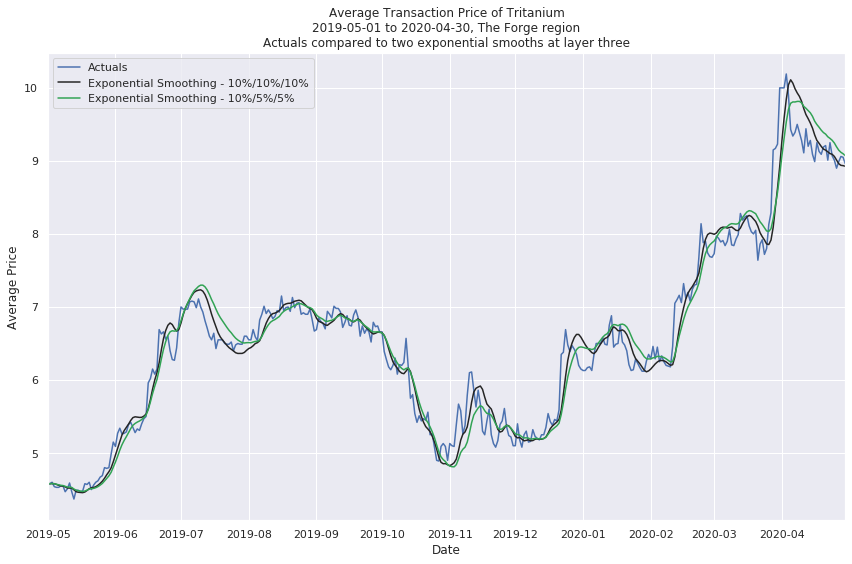

In [28]:
plt.figure(figsize=(12,8))
p = sns.lineplot(x=working_data.index, y=working_data[34], label='Actuals')
p = sns.lineplot(x=working_data.index, y=accel_10_actuals, label='Exponential Smoothing - 10%/10%/10%', color='#252525')
p = sns.lineplot(x=working_data.index, y=accel_10_5_actuals, label='Exponential Smoothing - 10%/5%/5%', color='#31a354')
_ = p.set(
    xlabel='Date', ylabel='Average Price',
    title='Average Transaction Price of Tritanium\n2019-05-01 to 2020-04-30, The Forge region\nActuals compared to two exponential smooths at layer three'
)
_ = p.set_xlim(*date_range)
plt.tight_layout()
p.get_figure().savefig('{}/avg_trit_jita_exp_smooth_10_5_5_and_10_10_10.png'.format(plot_dir))

In [52]:
smooth = Smoother(np.log(market_data[10000002]['average']), dims=4, horizon=14, verbose=True, tqdm_leave=False)
smooth.learn(1000, learn_rate=1e-1)
autosmooth_data = np.exp(pd.Series(smooth.state[:,0,0].detach().cpu().numpy(), index=smooth.index))

No seed data provided, using first row of data_frame.
Seed data one dimensional, generating 3 0-value derivative dimensions.


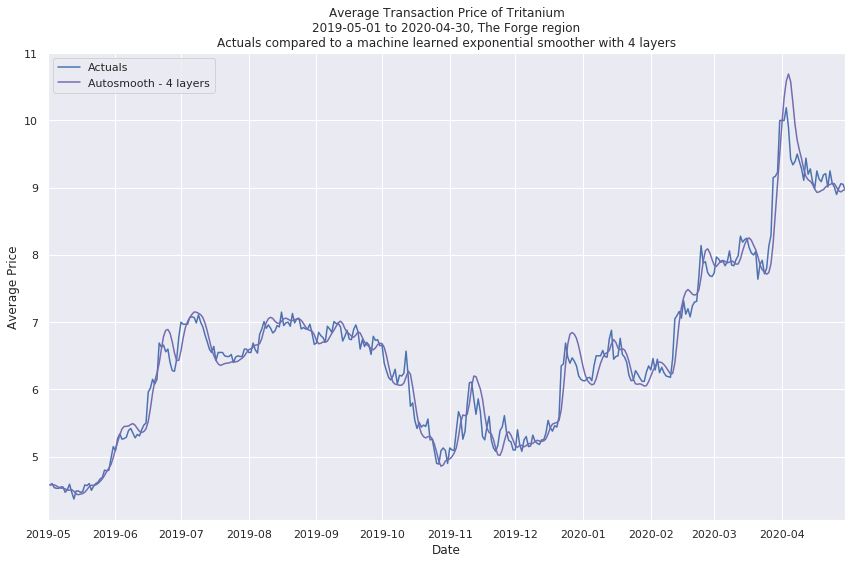

In [53]:
plt.figure(figsize=(12,8))
p = sns.lineplot(x=working_data.index[1:], y=working_data[34].iloc[1:], label='Actuals')
p = sns.lineplot(x=working_data.index[1:], y=autosmooth_data, label='Autosmooth - 4 layers', color='#756bb1')
_ = p.set(
    xlabel='Date', ylabel='Average Price',
    title='Average Transaction Price of Tritanium\n2019-05-01 to 2020-04-30, The Forge region\nActuals compared to a machine learned exponential smoother with 4 layers'
)
_ = p.set_xlim(*date_range)
plt.tight_layout()
p.get_figure().savefig('{}/avg_trit_jita_exp_autosmooth.png'.format(plot_dir))